Benchmark Models: Random Forest and LSTMs

In [6]:
# import necessary modules
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier

In [3]:
# import dataset
merged_df = pd.read_csv('merged_df.csv')

Preprocessing Pipeline

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Define target variables and feature variables
X = merged_df.drop(columns=['DEP_DATE_TIME', 'ACC_DEP_TIME', 'DEP_DELAY_NEW', 'DEP_DELAY_GROUP'])
y = merged_df['DEP_DELAY_GROUP']

# Replace -2 and -1 with 0 in the target labels
y = y.replace({-2: 0, -1: 0})

# Define numerical and categorical columns
categorical_cols = ['ORIGIN', 'DEST']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure encoder learns all categories, even those missing in training
all_categories = {col: X[col].unique() for col in categorical_cols}

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(categories=[all_categories[col] for col in categorical_cols], drop='first', handle_unknown='ignore'), categorical_cols)
    ])

# Preprocess the data (Fit on training data and transform both training and test data)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Convert to PyTorch tensors
X_train_torch = torch.FloatTensor(X_train_processed.toarray())  # Convert sparse matrix to dense
Y_train_torch = torch.LongTensor(Y_train.values)  # Convert target variable to tensor
X_test_torch = torch.FloatTensor(X_test_processed.toarray())  # Convert sparse matrix to dense
Y_test_torch = torch.LongTensor(Y_test.values)  # Convert target variable to tensor

# Normalize data
scaler = StandardScaler()
X_train_torch = torch.tensor(scaler.fit_transform(X_train_torch), dtype=torch.float32)
X_test_torch = torch.tensor(scaler.transform(X_test_torch), dtype=torch.float32)

# Generate feature names after OneHotEncoding for categorical columns
categorical_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(categorical_feature_names)

# Debugging: Print categories learned by OneHotEncoder
print("Categories learned by OneHotEncoder:", preprocessor.named_transformers_['cat'].categories_)

# Now feature_names is the list of all the feature names you need for plotting
print("Feature names:", feature_names)

Categories learned by OneHotEncoder: [array(['JFK'], dtype=object), array(['LAX', 'SFO', 'SJU', 'PHX', 'TPA', 'RSW', 'FLL', 'PBI', 'BQN',
       'MCO', 'ATL', 'MIA', 'STT', 'MSY', 'LAS', 'BOS', 'SLC', 'SRQ',
       'MSP', 'BUR', 'DEN', 'HOU', 'LGB', 'SYR', 'JAX', 'SEA', 'AUS',
       'PWM', 'RIC', 'RDU', 'OAK', 'IAD', 'DTW', 'ORD', 'BTV', 'BUF',
       'ROC', 'SAN', 'DCA', 'CLT', 'PIT', 'CVG', 'PHL', 'BWI', 'EGE',
       'MCI', 'BGR', 'CLE', 'SJC', 'SMF', 'ALB', 'BDL', 'IAH', 'PDX',
       'IND', 'STL', 'MKE', 'BNA', 'ORF', 'PSE', 'DFW', 'CMH', 'MEM',
       'ACK', 'SNA', 'SAT', 'LWB', 'MVY', 'HNL', 'PSP', 'CHS', 'SDF',
       'ABQ', 'BHM', 'JAC', 'SAV', 'HYA', 'RNO', 'DAB', 'TUS', 'ORH'],
      dtype=object)]
Feature names: ['CANCELLED', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'HOURLYVISIBILITY', 'HOURLYRelativeHumidity', 'HOURLYWindSpeed', 'HOURLYStationPressure', 'HOURLYSeaLevelPressure', 'HOURLYPrecip', 'HOURLYAltimeterSetting', 'HOUR

Random Forest

c:\Users\mhair\mlpractical\mlp\MLP_Project\mlpc\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mhair\mlpractical\mlp\MLP_Project\mlpc\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training Set Metrics:
Accuracy: 0.8394
Precision: 0.7046
Recall: 0.8394
F1-score: 0.7661

Test Set Metrics:
Accuracy: 0.8391
Precision: 0.7041
Recall: 0.8391
F1-score: 0.7657


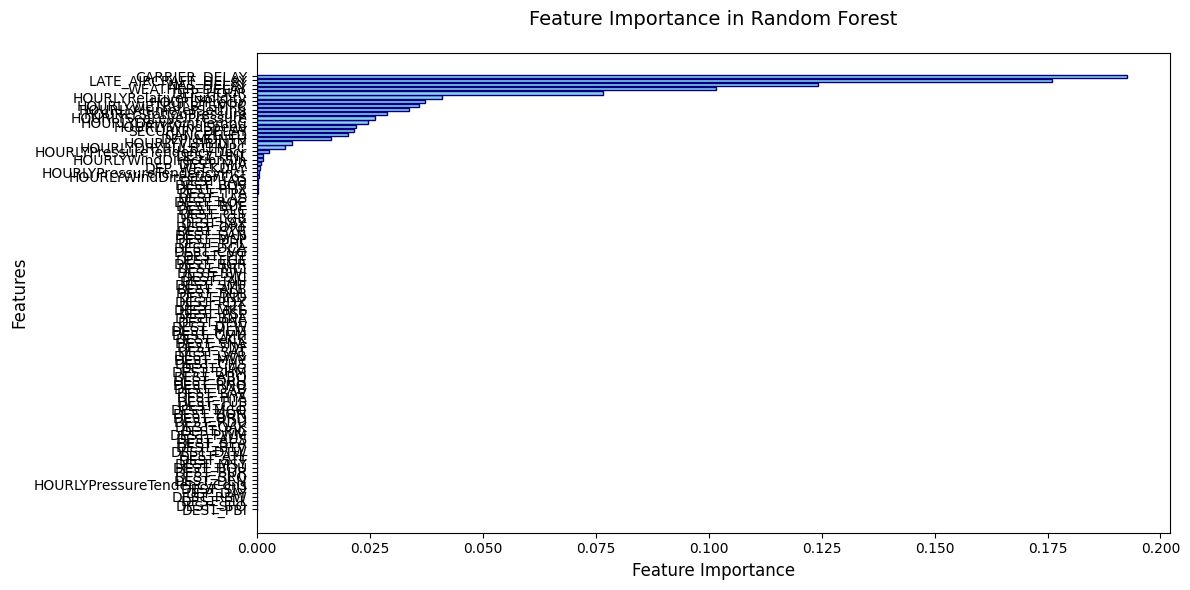

In [14]:
# Initialize and train a Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    max_depth=2,       # Max depth for each tree
    min_samples_leaf=100,  # Minimum samples per leaf
    min_samples_split=50,  # Minimum samples to split a node
    max_leaf_nodes=12,  # Max leaf nodes for each tree
    random_state=42
)

# Train the Random Forest model
rf_model.fit(X_train_torch.numpy(), Y_train_torch.numpy())  # Convert tensors to NumPy arrays for scikit-learn

# Predict on the training and test sets
y_pred_train = rf_model.predict(X_train_torch.numpy())
y_pred_test = rf_model.predict(X_test_torch.numpy())

# Calculate metrics for training and test sets
train_accuracy = accuracy_score(Y_train_torch.numpy(), y_pred_train)
train_precision = precision_score(Y_train_torch.numpy(), y_pred_train, average='weighted')
train_recall = recall_score(Y_train_torch.numpy(), y_pred_train, average='weighted')
train_f1 = f1_score(Y_train_torch.numpy(), y_pred_train, average='weighted')

test_accuracy = accuracy_score(Y_test_torch.numpy(), y_pred_test)
test_precision = precision_score(Y_test_torch.numpy(), y_pred_test, average='weighted')
test_recall = recall_score(Y_test_torch.numpy(), y_pred_test, average='weighted')
test_f1 = f1_score(Y_test_torch.numpy(), y_pred_test, average='weighted')

# Print the metrics
print(f'\nTraining Set Metrics:')
print(f'Accuracy: {train_accuracy:.4f}')
print(f'Precision: {train_precision:.4f}')
print(f'Recall: {train_recall:.4f}')
print(f'F1-score: {train_f1:.4f}')

print(f'\nTest Set Metrics:')
print(f'Accuracy: {test_accuracy:.4f}')
print(f'Precision: {test_precision:.4f}')
print(f'Recall: {test_recall:.4f}')
print(f'F1-score: {test_f1:.4f}')

# Feature importance plot for Random Forest
plt.figure(figsize=(12, 6))
importance_data = pd.DataFrame({
    'Feature': feature_names,  # Use the feature names obtained after preprocessing
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=True)

plt.barh(importance_data['Feature'], 
         importance_data['Importance'],
         color='skyblue',
         edgecolor='navy')

plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance in Random Forest', fontsize=14, pad=20)
plt.tight_layout()

# Save the feature importance plot
plt.savefig('rf_feature_importance_plot.png',
            dpi=300,
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none')

# Show the plot
plt.show()

LSTM model

In [18]:
# Define your LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)  # LSTM layer
        self.fc = nn.Linear(hidden_size, num_classes)  # Fully connected layer to output the classes

    def forward(self, x):
        # Reshape the input to have sequence length = 1
        x = x.unsqueeze(1)  # Adding a dimension to make it (batch_size, 1, input_size)
        
        # Pass through LSTM
        out, _ = self.lstm(x)
        
        # Get the output of the last time step
        out = out[:, -1, :]
        
        # Pass through the fully connected layer
        out = self.fc(out)
        return out

# Set up model hyperparameters
input_size = X_train_torch.shape[1]  # The number of features (input dimension)
hidden_size = 64  # Number of LSTM units
num_classes = len(Y_train.unique())  # Number of unique classes in target variable

# Instantiate the model
model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # Since it's a classification task
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 10  # Set the number of epochs
batch_size = 64  # You can adjust the batch size based on your system's capacity

# DataLoader setup for batching
from torch.utils.data import DataLoader, TensorDataset

train_data = TensorDataset(X_train_torch, Y_train_torch)
test_data = TensorDataset(X_test_torch, Y_test_torch)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(batch_x)  # Forward pass
        loss = criterion(outputs, batch_y)  # Calculate the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the weights

    # Optionally, print the loss every few epochs
    if (epoch+1) % 2 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model on the test set
model.eval()  # Set the model to evaluation mode
y_pred_test = []
y_true_test = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)  # Get predictions
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        y_pred_test.extend(predicted.cpu().numpy())  # Convert to numpy and append
        y_true_test.extend(batch_y.cpu().numpy())  # Convert to numpy and append

# Calculate metrics
test_accuracy = accuracy_score(y_true_test, y_pred_test)
test_precision = precision_score(y_true_test, y_pred_test, average='weighted')
test_recall = recall_score(y_true_test, y_pred_test, average='weighted')
test_f1 = f1_score(y_true_test, y_pred_test, average='weighted')

# Print metrics
print(f'\nTest Set Metrics:')
print(f'Accuracy: {test_accuracy:.4f}')
print(f'Precision: {test_precision:.4f}')
print(f'Recall: {test_recall:.4f}')
print(f'F1-score: {test_f1:.4f}')

# Optionally, plot confusion matrix or other visualizations

Epoch [2/10], Loss: 0.1032
Epoch [4/10], Loss: 0.2792
Epoch [6/10], Loss: 0.1977
Epoch [8/10], Loss: 0.2045
Epoch [10/10], Loss: 0.4772

Test Set Metrics:
Accuracy: 0.9339
Precision: 0.9301
Recall: 0.9339
F1-score: 0.9316


to do:
- LSTM: edit so that it has the same output as LR (e.g. loss and accuracy, training and test measures and graphs across epochs)
- LSTM add confusion matrix
- RF: edit to have clear graphs
- RF: add tree graph of final tree?
- consider parameters more closely